In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from util_functions import plot_feature_with_anomalies, resample_data, find_irradiance_threshold, identify_static_features, filter_active_hours, clip_values, wavelet_denoise, savitzky_golay, rolling_median_filter

In [47]:
# Set Pandas to display all columns (None means no limit on the number of columns displayed)
pd.set_option('display.max_columns', None)

# Set option to display float format
pd.set_option('display.float_format', lambda x: '%.3f' % x) # This will help avoid issue of numeric values that are in the form of power (scientific notation) when you load them with pandas

In [48]:
# Function to check if variable is defined
def is_defined(variable_name):
    return variable_name in globals()

# Initial file paths
dasiv01 = 'Original_labeled_datasets/dt1_solar_and_meteorological_measurement.csv'
dasiv02 = 'Original_labeled_datasets/dt2_electrical_production_inverter_1_with_faults.csv'

# load the data if it is not already loaded
while not (is_defined('weather_data') and is_defined('df1')):
            weather_data = pd.read_csv(dasiv01, index_col='time')
            print("Weather data loaded successfully.")

            df1 = pd.read_csv(dasiv02, index_col='time')
            print("Electrical production data loaded successfully.")

            # Join the two datasets
            df1 = df1.join(weather_data)
            df1.index = pd.to_datetime(df1.index)
            df1.index = df1.index.tz_convert(None) # Remove timezone information to avoid issues with decomposition

df = df1.copy()

In [49]:
# rename the columns
df.rename(columns={'GTI': 'global_tilted_irradiance', 
                   'DTI': 'diffuse_tilted_irradiance', 
                   'TA': 'ambient_temperature', 
                   'TPV': 'panel_temperature', 
                   'Eg': 'energy_injected',
                   'Pg': 'power_injected', 
                   'Ia': 'ambient_current', 
                   'Ig': 'current_injected',
                   'Va': 'pv_plant_voltage',
                   'Vg': 'grid_voltage',
                   'Fg': 'grid_frequency'}, inplace=True)

#### Apply de-trending and de-seasoning

In [50]:
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning

warnings.filterwarnings("ignore", category=InterpolationWarning)

### Identify the active hours

In [51]:
def apply_find_irradiance_threshold(df, percentile=1):
    return find_irradiance_threshold(df, percentile=percentile)

df['month'] = df.index.month
monthly_thresholds = df.groupby('month').apply(apply_find_irradiance_threshold)
df = filter_active_hours(df, monthly_thresholds)

print("Monthly thresholds:")
print(monthly_thresholds)

C:\Users\AZIZON\AppData\Local\Temp\ipykernel_8032\3189523263.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_thresholds = df.groupby('month').apply(apply_find_irradiance_threshold)


Monthly thresholds:
month
1    38.500
2    41.270
3    49.490
4    48.110
5    39.910
6    39.890
7    39.890
8    46.770
9    53.650
10   55.020
11   46.740
12   45.390
dtype: float64


#### Address outliers by capping their values

In [52]:
# resample the data to speed up the process
df_resampled = resample_data(df, '10min')
df_resampled = df_resampled.dropna()

# identify static features
static_features = identify_static_features(df_resampled.drop(columns=['Fault']))
print("Static features:", static_features)

# Clip the values of the static features
for feature in static_features:
    df[feature] = clip_values(df[feature], lower_percentile=0.001, upper_percentile=0.999)

Static features: ['ambient_current', 'current_injected', 'grid_frequency']


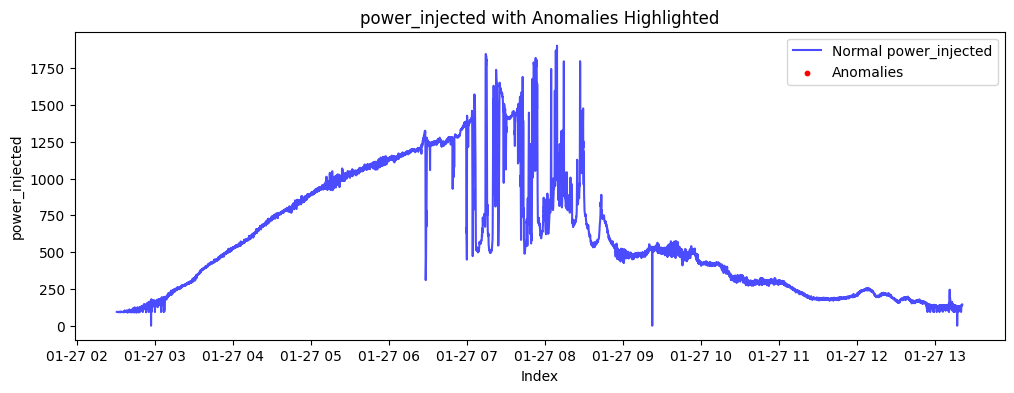

In [53]:
feature = 'power_injected'
start_date = '2022-01-27'
end_date = pd.to_datetime(start_date) + pd.Timedelta(days=1)

plot_feature_with_anomalies(df[start_date:end_date], feature)
# plot_feature_with_anomalies(df_cleaned[start_date:end_date], feature)

### Denoise the data

In [54]:
# Apply the function to your dataframe
df = rolling_median_filter(df, window=3)

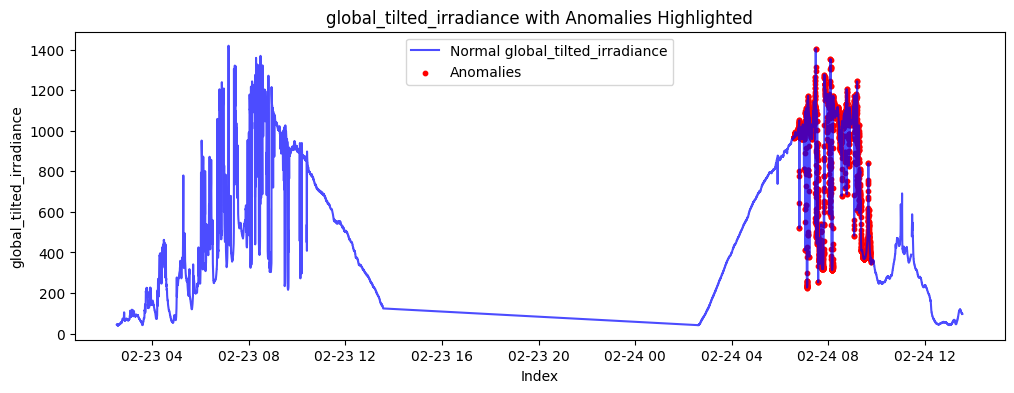

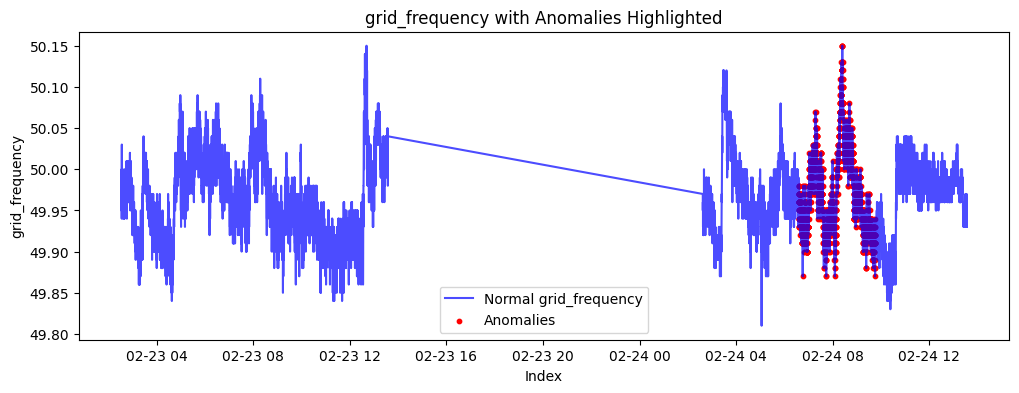

In [55]:
feature = 'global_tilted_irradiance'
feature_2 = 'grid_frequency'
start_date = '2022-02-23'
end_date = pd.to_datetime(start_date) + pd.Timedelta(days=2)

plot_feature_with_anomalies(df[start_date:end_date], feature)
plot_feature_with_anomalies(df[start_date:end_date], feature_2)

### Resample the data

In [56]:
df = resample_data(df, interval='10min')

df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

<Axes: >

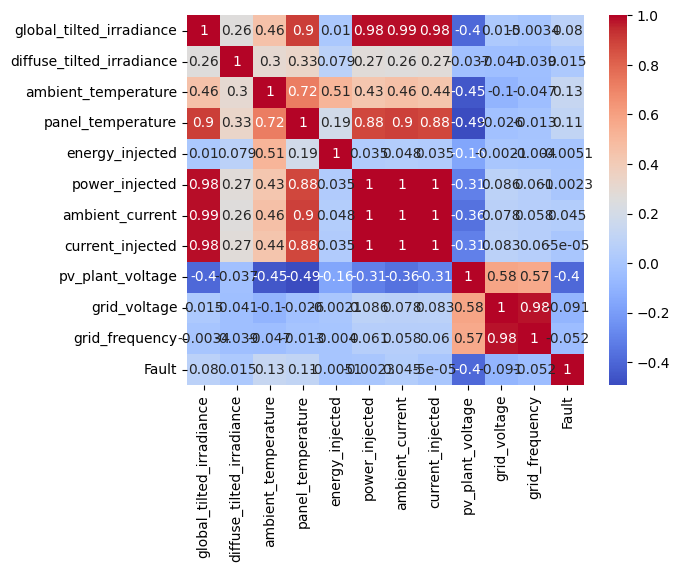

In [57]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the correlation heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

### Change the values of Fault column. Set the values to 1 if they are not equal to 0.

In [58]:
# convert other fault types to 1
df['Fault'] = df['Fault'].apply(lambda x: 1 if x != 0 else 0)

### Reorder the columns

In [59]:
# Get all column names except 'fault'
cols = [c for c in df.columns if c != 'Fault']

# Append 'fault' column at the end
cols.append('Fault')

# Reorder the DataFrame using the new column order
df = df[cols]

In [60]:
# choose the directory of where GNNAD_testing files are located
df[:'2022-07-01'].to_csv('for_cross_validation.csv', index=True)